## Explain an Intermediate Layer of VGG16 on ImageNet
Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the 7th layer of the pretrained VGG16 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
tf.compat.v1.disable_v2_behavior()
import shap
import tensorflow.keras.backend as K
import json


# HACK: TODO: 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
to_explain.shape

(2, 224, 224, 3)

In [5]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.layers[layer].input, feed_dict)

(2, 2)
2


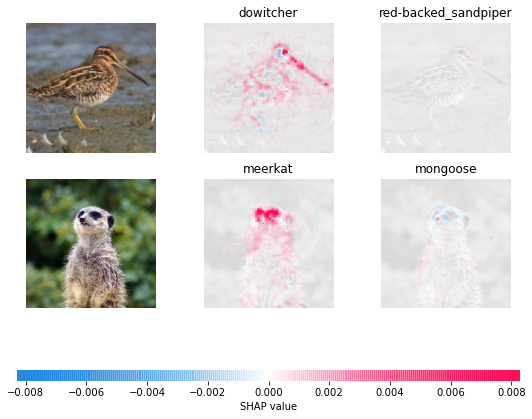

In [12]:
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
print(index_names.shape)
print(len(shap_values))
# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

## Explain with local smoothing
Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

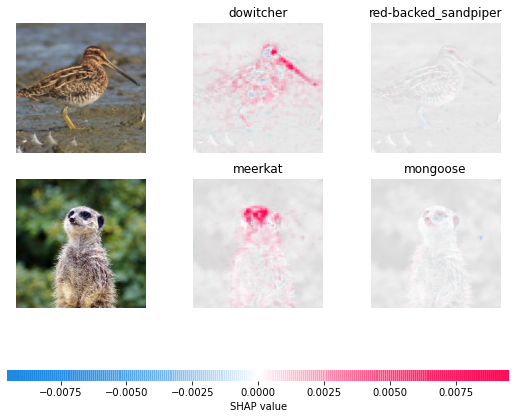

In [5]:
# explain how the input to the 7th layer of the model explains the top two classes
explainer = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), 7),
    local_smoothing=100
)
shap_values,indexes = explainer.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)